# **Procesamiento de datos a gran escala**

<h2>Clustering</h2>

**Autor:** Juan Felipe González Quintero

**Fecha:** 5-11-2025

## **Problemática**

Se tiene que el tratamiento del agua debe ser indispensable para garantizar la pureza y la calidad. Uno de los elementos significativos es aplicar los conceptos de los Procesamiento de Datos en Alto Volúmen para solucionar este tipo de problemas que afectan la salud pública. El presente ejemplo tiene como propósito tener en cuenta una metodología para aplicar el PAVD para solucionar o diagnósticar la calidad del agua en la India.

## **Objetivo**

El objetivo de este cuaderno es aplicar el algoritmo de clustering a un conjunto de datos sencillos.


<h2>Indice</h2>

<div class="alert alert-block alert-info" style="margin-top: 20px">
<ul>
  <li>Cargar los Datos</li>
  <li>Aplicando Algortimo K-Medias</li>
</ul>

Tiempo estimado: <strong>10 min</strong>

</div>
<hr>

## **Carga de datos**

Para este ejercicio se estará utilizando el conjunto de datos Iris, la cual es una fuente en línea en formato CSV (valores separados por coma).
<p> Este set de datos posee diferentes medidas sobre la planta Iris y es famosamente utilizado como ejemplo en analítica de datos:
  </p>
Se utiliza este conjunto para ejemplificar la creación de clusters:

<ul>
  <li>descripción: <a href="https://archive.ics.uci.edu/ml/datasets/Iris" target="_blank">https://archive.ics.uci.edu/ml/datasets/Iris</a></li>
  <li>fuente de datos: <a href="https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data" target="_blank">https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data</a></li>
    <li>tipo de datos: csv</li>

Se va a utilizar la librería Pandas de Python para realizar la lectura de archivos. Se cargan los datos, se agregan cabeceras y se muestra el resultado:

## **Instalación de Librerías y Configuración de la Sesión Spark**

In [1]:
import sys
print(sys.executable)

/home/estudiante/miniconda3/bin/python3


In [2]:
#Importación de todas las bibliotecas necesarias para procesamiento, gráficas y otros recursos
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

# Bibliotecas especializadas
from pylab import *

In [3]:
import os

# Ajuste de las variables de entorno
os.environ["PYSPARK_PYTHON"] = "/home/estudiante/miniconda3/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON"] = "/home/estudiante/miniconda3/bin/python3"

print("Usando Python en:", os.environ["PYSPARK_PYTHON"])

Usando Python en: /home/estudiante/miniconda3/bin/python3


In [4]:
# Bibliotecas de Contexto PySpark, MLlib y contexto para levantar la sesión de PYSPARK

#Búsqueda de inicialización para pyspark
import findspark
findspark.init()

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F # Acceso a todas las funciones

from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator

In [5]:
#Se crea una sesión para hacer el contexto de procesamiento desde mi Cuota de cluster HPC (No tenemos acceso a todos los cores, son compartidos)
from pyspark import SparkConf
##Se levanta la configuración de mi Cuota
configura = SparkConf().set("spark.scheduler.mode", "FAIR")

configura.setAppName("HPC_Gonzalez")

sparkNoSupervisadoG = SparkSession.builder.config(conf=configura).getOrCreate()
SQLContext(sparkContext = sparkNoSupervisadoG.sparkContext, sparkSession = sparkNoSupervisadoG)

contextoSparkNoSpuervisadoG = sparkNoSupervisadoG.sparkContext.getOrCreate()

print("Sesión cluster HPC: Gonzalez LabNoSupervisado")

sparkNoSupervisadoG

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/05 09:07:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/11/05 09:07:57 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Sesión cluster HPC: Gonzalez LabNoSupervisado


In [6]:
# Leer datos desde archivo CSV
local_path ="/almacen/csv/iris.data"

schema = StructType([StructField("sepal_length", FloatType(), True),
                     StructField("sepal_width",  FloatType(), True),
                     StructField("petal_length", FloatType(), True),
                     StructField("petal_width",  FloatType(), True),
                     StructField("Species",        StringType(), True)])


df00 = sparkNoSupervisadoG.read.format("csv").option("header", "false").schema(schema).load(local_path)

df00.show(5)

+------------+-----------+------------+-----------+-----------+
|sepal_length|sepal_width|petal_length|petal_width|    Species|
+------------+-----------+------------+-----------+-----------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|
+------------+-----------+------------+-----------+-----------+
only showing top 5 rows



In [7]:
#Se exploran los tipos de variables del conjunto de datos
df00.printSchema()

root
 |-- sepal_length: float (nullable = true)
 |-- sepal_width: float (nullable = true)
 |-- petal_length: float (nullable = true)
 |-- petal_width: float (nullable = true)
 |-- Species: string (nullable = true)



In [8]:
#Se realiza el conteo de nulos en el conjunto de datos para asegurar coherencia con los pasos siguientes
df00.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df00.columns]).show()

+------------+-----------+------------+-----------+-------+
|sepal_length|sepal_width|petal_length|petal_width|Species|
+------------+-----------+------------+-----------+-------+
|           0|          0|           0|          0|      0|
+------------+-----------+------------+-----------+-------+




### Aplicar Indexador a Columna "Species"

In [9]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
# StringIndexer Initialization
indexer = StringIndexer(inputCol="Species", outputCol="Species_Indexed")
indexerModel = indexer.fit(df00)

# Transform the DataFrame using the fitted StringIndexer model
indexed_df = indexerModel.transform(df00)
indexed_df.show()

+------------+-----------+------------+-----------+-----------+---------------+
|sepal_length|sepal_width|petal_length|petal_width|    Species|Species_Indexed|
+------------+-----------+------------+-----------+-----------+---------------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|            0.0|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|            0.0|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|            0.0|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|            0.0|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|            0.0|
|         5.4|        3.9|         1.7|        0.4|Iris-setosa|            0.0|
|         4.6|        3.4|         1.4|        0.3|Iris-setosa|            0.0|
|         5.0|        3.4|         1.5|        0.2|Iris-setosa|            0.0|
|         4.4|        2.9|         1.4|        0.2|Iris-setosa|            0.0|
|         4.9|        3.1|         1.5| 

In [9]:
#Se verifica los distintos tipos de especies de plantas que se encuentran en el conjunto de datos
indexed_df.select('Species').distinct().collect()

[Row(Species='Iris-virginica'),
 Row(Species='Iris-setosa'),
 Row(Species='Iris-versicolor')]

## **Aplicar Algortimo K-Medias**

A continuación se procede a aplicar el algoritmo K-Means, **una técnica de clustering no supervisado que agrupa datos en un número determinado de categorías o clusters (K) según su similitud.** Su objetivo es minimizar la distancia entre los puntos de cada grupo y su centroide (el punto medio del grupo). Funciona de forma iterativa: primero asigna aleatoriamente los centroides, luego agrupa los datos según el centroide más cercano y finalmente recalcula los centroides hasta que las asignaciones no cambian significativamente.

Para esto, el primer paso es separar en un dataframe aparte las variables numéricas del conjunto de datos ya que estas serán las que serán manipuladas aplicando el algoritmo.

In [11]:
#Se crea el dataframe que solo contiene los valores numéricos del conjunto de datos
df_kmeans = df00[["sepal_length","sepal_width","petal_length","petal_width"]]
df_kmeans.show(5)

+------------+-----------+------------+-----------+
|sepal_length|sepal_width|petal_length|petal_width|
+------------+-----------+------------+-----------+
|         5.1|        3.5|         1.4|        0.2|
|         4.9|        3.0|         1.4|        0.2|
|         4.7|        3.2|         1.3|        0.2|
|         4.6|        3.1|         1.5|        0.2|
|         5.0|        3.6|         1.4|        0.2|
+------------+-----------+------------+-----------+
only showing top 5 rows



### Formatear los datos usando Vector Assembler en los vectores los cuales serán usados como "features"

Se hace uso de la biblioteca de PySpark VectorAssembler, que se usa para preparar los datos antes de aplicar un modelo de machine learning. En este caso, PySpark exige que todas las variables que se van a usar en un modelo (por ejemplo, las columnas numéricas de un DataFrame) estén combinadas en una sola columna llamada normalmente features, que contiene un vector de características para cada observación. 

In [12]:
#Importación de la biblioteca VectorAssembler
from pyspark.ml.feature import VectorAssembler

#Uso de VectorAssembler para la generación de la columna "features"
assembler = VectorAssembler(inputCols = df_kmeans.columns, outputCol='features')
df_datos = assembler.transform(df00)

### Escalar los datos

In [14]:
# Importar el StandardScaler
from pyspark.ml.feature import StandardScaler

# Crear el escalador: normaliza la columna 'features' generada por el VectorAssembler
escalador = StandardScaler(
    inputCol="features",
    outputCol="scaledFeatures",
    withStd=True,   # Escala con la desviación estándar
    withMean=False  # Si lo pones True, centra en la media (no siempre recomendable para KMeans)
)

# Ajustar el escalador con los datos
modeloEscalado = escalador.fit(df_datos)

# Transformar el DataFrame para añadir la columna escalada
df_datos = modeloEscalado.transform(df_datos)

df_datos.show(5)


+------------+-----------+------------+-----------+-----------+--------------------+--------------------+
|sepal_length|sepal_width|petal_length|petal_width|    Species|            features|      scaledFeatures|
+------------+-----------+------------+-----------+-----------+--------------------+--------------------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|[5.09999990463256...|[6.15892840615775...|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|[4.90000009536743...|[5.91740202781600...|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|[4.69999980926513...|[5.67587507362994...|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|[4.59999990463256...|[5.55511188445906...|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|[5.0,3.5999999046...|[6.03816521698687...|
+------------+-----------+------------+-----------+-----------+--------------------+--------------------+
only showing top 5 rows



### Encontrar el número de clusters usando Silhouette Score

In [15]:
#Importing the model
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_score=[]

evaluador = ClusteringEvaluator(predictionCol='prediction',
                                featuresCol='scaledFeatures', \
                                metricName='silhouette', 
                                distanceMeasure='squaredEuclidean')

for i in range(2,10):
    kmeans=KMeans(featuresCol='scaledFeatures', k=i)
    KMeans_fit=kmeans.fit(df_datos)
    output = KMeans_fit.transform(df_datos)   
    score = evaluador.evaluate(output)   
    silhouette_score.append(score)
    print('Silhouette Score for k =',i,'is',score)

25/11/05 09:19:29 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Silhouette Score for k = 2 is 0.7714149115179729
Silhouette Score for k = 3 is 0.6535875461939223
Silhouette Score for k = 4 is 0.5906029865156707
Silhouette Score for k = 5 is 0.5834673300062634
Silhouette Score for k = 6 is 0.5034590366683188
Silhouette Score for k = 7 is 0.5334556949990061
Silhouette Score for k = 8 is 0.5667950059936975
Silhouette Score for k = 9 is 0.5042283433156114


### Visualización de silhouette scores

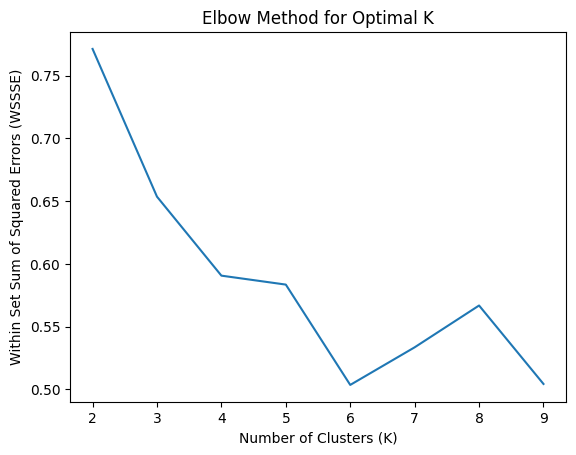

In [16]:
import matplotlib.pyplot as plt

plt.plot(range(2,10),silhouette_score)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within Set Sum of Squared Errors (WSSSE)')
plt.title('Elbow Method for Optimal K')
plt.show()

Para seleccionar la cantidad de clústers en los que se agrupará se tienen en cuenta dos conceptos que están estrechamente relacionados.

**1. Silhouette Score**

Este valor mide que tan bien separado está cada uno de los clústers, siendo que:

- Un valor cercano a 1 indica clusters bien definidos.
- Un valor cercano a 0 indica que los puntos están en el límite entre dos clusters.
- Un valor negativo indica clusters solapados o mal formados.

En este caso, vemos que el valor de k=2 es el más alto, lo que indica clústers mejor definidos, este podría no ser el mejor a la hora de seleccionar debido a que es una segmentación demasiado general, por lo que podrían estarse agrupando datos que podrían pertenecer a categorías distintas. Por otro lado, valores muy bajos podrían indicar que se pierde poco a poco la segmentación entre clústers, por lo que valores como los que presenta k=6 no serían adecuados.

**2. Método del codo**

En la gráfica generada a través de los valores obtenidos para el error cuadrático (WSEE), se puede acudir al llamado "método del codo" que busca el punto donde la curva deja de decrecer abruptamente y empieza a estabilizarse. Ese punto se considera el “codo” y representa un equilibrio entre cohesión interna (los puntos dentro de un cluster están cerca entre sí) y separación entre clusters.

En la visualización se observa una caída pronuncida en los valores hasta donde se ubican k=3 y k=4 donde el decrecimiento empieza a ser un poco más estable tendiendo a ciertos valores cerca de 0.53 y 0.56.

### **Selección de K**

De acuerdo al funcionamiento de los dos criterios tenidos en cuenta para escoger el mejor k posible, se puede decir que k=3 sería el más indicado, esto debido a que es el punto en el cuál se representa el equilibrio ideal entre la reducción significativa del error (observada en el método del codo) y una adecuada separación entre grupos (reflejada en el silhouette score).

Este equilibrio está mejor representado en el punto k=3 ya que, por ejemplo, para k=8 se encuentra un pico local en los valores del Silhouette Score que también seve reflejado en la gráfica, esto posiblemente debido a que La aleatoriedad del algoritmo K-Means (ya que las inicializaciones pueden generar configuraciones de centroides más afortunadas en algunos casos), o bien, que alguno de los clusters anteriores (por ejemplo, en k=7) se dividió en dos grupos ligeramente más compactos. Sin embargo, esto no significa que el modelo global mejore necesariamente, ya que la estabilidad o tendencia de los valores del error cuadrático se encuentra antes, además de que el modelo se vuelve más complejo con k=8 sin ganar interpretabilidad ni una mejora significativa en cohesión global.

Otros valores comparables podrían ser k=6 donde se observa una caída abrupta, posiblemente porque el algoritmo generó sobresegmentación, es decir, se realizaron divisiones de grupos naturales en grupos sin sentido estadístico; o también podría compararse k=4 que es el más cercano en términos de la gráfica al punto de estabilización que se busca, sin embargo, su valor de Silhouette Score está mucho más cerca de k=5 que de k=3, perdiendo ese equilibrio entre alta cohesión y bajo acoplamiento de clústers.

En conclusión, basándose en los valores estadísiticos definidos y el comportamiento de los mismos con el incremento de K, **la mejor elección es k=3 que considera un equilibrio entre alta cohesión (un valor alto de Silhouette Score) y bajo acoplamiento.**

## **Entrenamiento del modelo**

Una vez escogido el k deseado, se procede a realizar el entrenamiento del modelo que nos permitirá realizar la segmentación

In [26]:
#Se configura el objeto Kmeans con los parámetros deseados y el k escogido en la sección anterior
kmeans = KMeans(k=3, featuresCol="scaledFeatures", predictionCol="cluster")
#Se entrena el modelo
kmeans_model = kmeans.fit(df_datos)

### Evaluar el modelo k=3 Within Set Sum of Squared Errors (WSSSE) metric

In [27]:
#Se calcula el error cuadrado para evaluar la selección de k
output = KMeans_fit.transform(df_datos)
wssse = evaluador.evaluate(output)
print(f"Within Set Sum of Squared Errors (WSSSE) = {wssse}")

Within Set Sum of Squared Errors (WSSSE) = 0.5042283433156114


In [22]:
output.printSchema()

root
 |-- sepal_length: float (nullable = true)
 |-- sepal_width: float (nullable = true)
 |-- petal_length: float (nullable = true)
 |-- petal_width: float (nullable = true)
 |-- Species: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- scaledFeatures: vector (nullable = true)
 |-- prediction: integer (nullable = false)



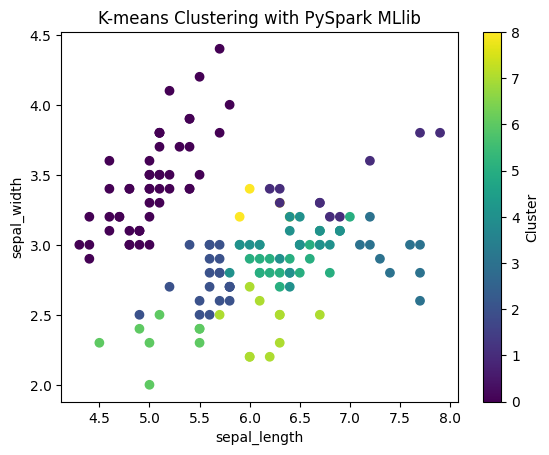

In [28]:
# Convertir a Pandas DataFrame
clustered_data_pd = output.toPandas()

# Visualización
plt.scatter(clustered_data_pd["sepal_length"], 
            clustered_data_pd["sepal_width"], 
            c=clustered_data_pd["prediction"], cmap='viridis')

plt.xlabel("sepal_length")
plt.ylabel("sepal_width")
plt.title("K-means Clustering with PySpark MLlib")
plt.colorbar().set_label("Cluster")
plt.show()

Esta gráfica muestra la distribución de los datos del conjunto Iris según las variables sepal_length y sepal_width, coloreadas por el clúster asignado por el modelo K-Means implementado con PySpark MLlib. Se observa que **el algoritmo logra separar claramente al menos un grupo compacto (en el extremo superior izquierdo), mientras que los demás presentan cierta superposición**, lo que indica que existen regiones donde **las flores tienen características similares y los límites entre clústeres no son tan definidos.**


### Visualizar los Datos

In [29]:
df_datos.columns

['sepal_length',
 'sepal_width',
 'petal_length',
 'petal_width',
 'Species',
 'features',
 'scaledFeatures']

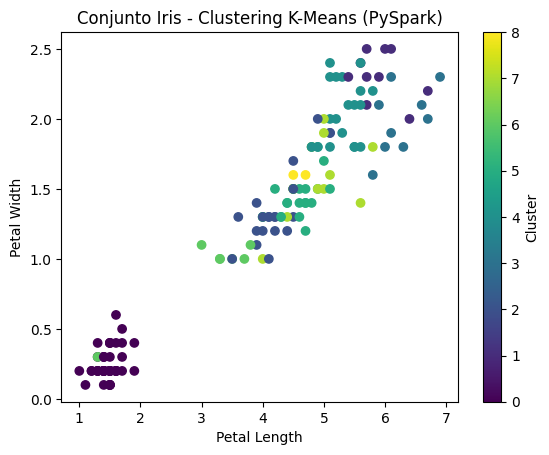

In [34]:
#Visualizando con Matplotlib
plt.scatter(
    x=clustered_data_pd["petal_length"],
    y=clustered_data_pd["petal_width"],
    c=clustered_data_pd["prediction"],  # o 'cluster' si la definiste así
    cmap='viridis'
)
plt.title("Conjunto Iris - Clustering K-Means (PySpark)")
plt.xlabel("Petal Length")
plt.ylabel("Petal Width")
plt.colorbar().set_label("Cluster")
plt.show()

En esta gráfica se visualiza el resultado del clustering K-Means aplicado al conjunto Iris utilizando las variables petal_length y petal_width (que suelen ser las más representativas para distinguir las especies de flores). **Se observa una separación mucho más clara entre los grupos:** el conjunto de puntos en la parte inferior izquierda corresponde claramente a una clase distinta, mientras que los otros grupos se distribuyen a lo largo de una diagonal ascendente, mostrando cierta superposición pero con una estructura más definida que en el gráfico anterior. Esto indica que **estas dos variables (petal_length y petal_width) tienen un mayor poder discriminante para la segmentación**, permitiendo que el modelo K-Means identifique con mayor precisión las distintas agrupaciones naturales dentro del conjunto de datos.

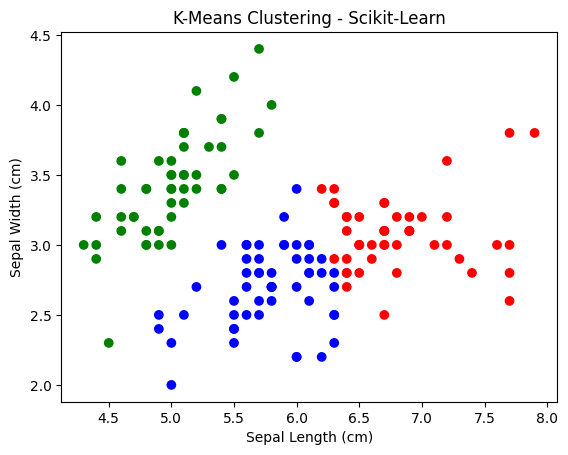

In [38]:
# Gráfico 2: Resultados con Scikit-Learn (colores fijos)
from sklearn.cluster import KMeans
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Carga del dataset
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)

# Entrenamiento
k_means = KMeans(n_clusters=3, random_state=42)
k_means.fit(df[['sepal length (cm)', 'sepal width (cm)']])

# Colores y gráfica
colors = np.array(['red', 'blue', 'green'])
plt.scatter(x=df['sepal length (cm)'], y=df['sepal width (cm)'], c=colors[k_means.labels_])
plt.title("K-Means Clustering - Scikit-Learn")
plt.xlabel("Sepal Length (cm)")
plt.ylabel("Sepal Width (cm)")
plt.show()


En esta gráfica se observa el resultado del clustering K-Means aplicado con Scikit-Learn utilizando las variables sepal length y sepal width. Los puntos de colores representan los diferentes grupos (clusters) que el algoritmo identificó. **Se puede notar que existe un grupo (en verde) claramente separado del resto, mientras que los otros dos (azul y rojo) presentan cierta superposición**, lo que indica que **estas dos variables no son suficientes por sí solas para una separación perfecta entre las especies.** En general, el modelo logra identificar correctamente una de las clases del conjunto Iris, pero muestra confusión entre las otras dos, reflejando que las dimensiones del sépalo tienen un poder de discriminación limitado en comparación con las del pétalo, donde las diferencias entre especies son más marcadas.

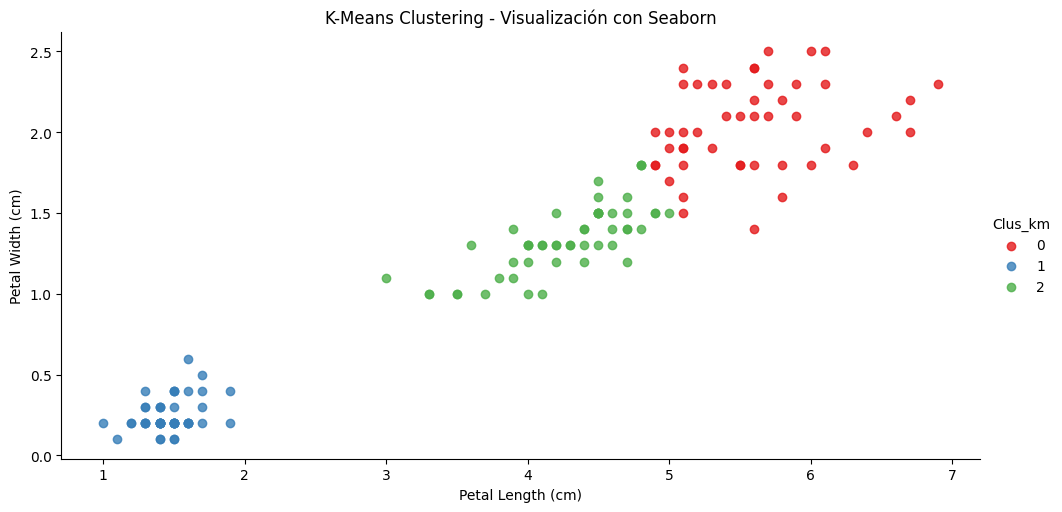

In [40]:
# Visualizando con Seaborn (versión corregida)
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import load_iris

# Cargar dataset Iris
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)

# Entrenar modelo K-Means
k_means = KMeans(n_clusters=3, random_state=42)
k_means.fit(df[['petal length (cm)', 'petal width (cm)']])

# Agregar etiquetas de cluster al DataFrame
df['Clus_km'] = k_means.labels_

# Graficar con Seaborn
sns.lmplot(
    x='petal length (cm)',
    y='petal width (cm)',
    data=df,
    hue='Clus_km',
    fit_reg=False,
    height=5,
    aspect=2,
    palette='Set1'
)

plt.title("K-Means Clustering - Visualización con Seaborn")
plt.xlabel("Petal Length (cm)")
plt.ylabel("Petal Width (cm)")
plt.show()


En esta gráfica se visualizan los resultados del clustering K-Means aplicados al conjunto Iris utilizando las variables petal length (largo del pétalo) y petal width (ancho del pétalo), representados con la librería Seaborn. Aquí se observa una separación mucho más clara entre los tres grupos (clusters), en comparación con las gráficas basadas en las dimensiones del sépalo.

El grupo azul (Clus_km = 1) corresponde probablemente a la especie Iris setosa, que presenta pétalos cortos y angostos y se distingue claramente del resto. Los grupos verde (Clus_km = 2) y rojo (Clus_km = 0) se superponen ligeramente, lo que podría reflejar la similitud entre Iris versicolor e Iris virginica. En conjunto, esta gráfica **evidencia que las características de los pétalos son las más adecuadas para separar las especies dentro del conjunto Iris**, mostrando un desempeño óptimo del algoritmo K-Means en esta proyección.

## **Conclusiones**